# **Яргин Захар**

Реализация модели для бинарной классификации по сопоставлению товаров между собой с целью детекции матчей. Используется гибридный подход из двух моделей. Первая модель это MLP для получения признаков от эмбеддингов, а вторая CatBoost для классификации. На выходе оптимизируем наш порог, тк данные несбалансированы.



In [35]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os 
import pickle
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [36]:
BATCH_SIZE = 512      #обучение сети
NUM_EPOCHS_NN = 7     #обучение сети
LEARNING_RATE = 0.001 #обучение сети
VAL_SPLIT = 0.2       #разбиение выборки
IMG_DIM = 256          # размер img эмбеддинга
TXT_DIM = 64           # размер txt эмбеддинга

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_PATH = '/kaggle/input/data'
SAVE_DIR = './models' 

### Загрузка данных и обработка

In [37]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')

print(f"Train samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(train_df['target'].value_counts())

Train samples: 2,518,441
Test samples: 363,835
target
0    2223798
1     294643
Name: count, dtype: int64


In [38]:
train_df.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


In [39]:
train_df.isnull().sum()

offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             407287
goods_category_id          833
target                       0
id                           0
dtype: int64

In [40]:
train_df.isnull().mean().sort_values(ascending=False)

goods_price             0.161722
goods_category_id       0.000331
offer_depersanalised    0.000000
goods_depersanalised    0.000000
sum_length              0.000000
offer_price             0.000000
attrs+title_score       0.000000
target                  0.000000
id                      0.000000
dtype: float64

In [41]:
# пропусков по goods_category_id не так много, можем их просто удалить
train_df = train_df.dropna(subset=['goods_category_id']).reset_index(drop=True) 

In [42]:
train_df.duplicated().sum()

np.int64(0)

In [43]:
# по goods_price пропусков много, заполним медианой по категориям
train_df['goods_price'] = train_df['goods_price'].where(
    train_df['goods_price'].notnull(),
    train_df.groupby('goods_category_id')['goods_price'].transform('median')
    )

In [44]:
train_df.isnull().sum()

offer_depersanalised    0
goods_depersanalised    0
sum_length              0
attrs+title_score       0
offer_price             0
goods_price             0
goods_category_id       0
target                  0
id                      0
dtype: int64

In [45]:
train_df.shape[0] #2518441

2517608

### Посмотрим на корреляцию числовых признаков, нет ли у нас каких-то линейных зависимостей в признаках и какие фичи сильнее всего влияют на таргет

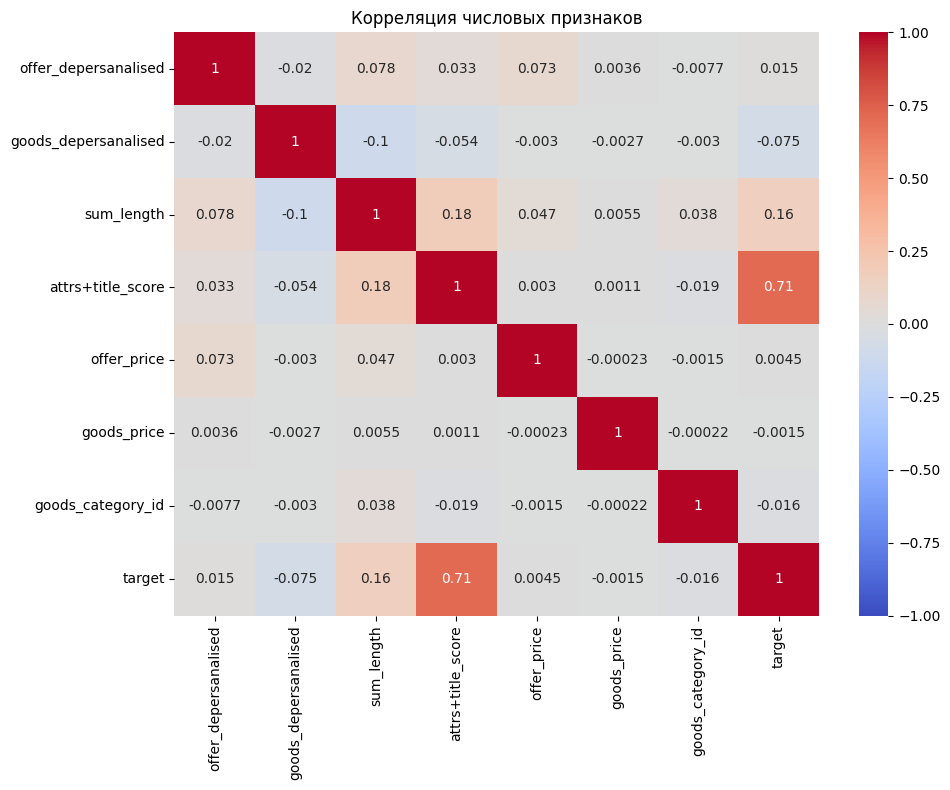

In [46]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr = train_df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Корреляция числовых признаков")
    plt.tight_layout()
    plt.show()
#больше всего на таргет влияет attrs+title_score

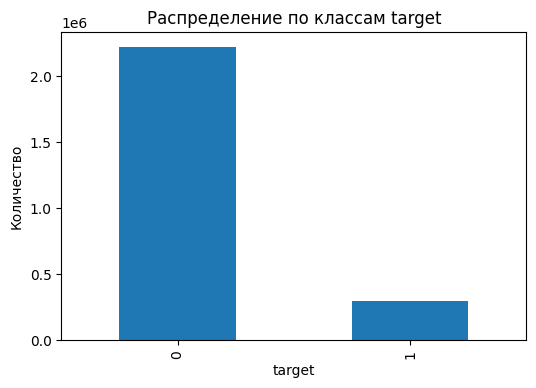

In [47]:
# Какое у нас вообще исходное распределение в данных
plt.figure(figsize=(6, 4))
train_df['target'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по классам target')
plt.xlabel('target')
plt.ylabel('Количество')
plt.show()

### Видим, что у нас сильный дисбаланс. После написания всего пайплайна была запущена модель с ratio 3,4,5,6,7 и обнаружено, что максимальный скор при соотношении данных 1к5.

In [48]:
class_0 = train_df[train_df['target'] == 0]
class_1 = train_df[train_df['target'] == 1]

n_samples = min(len(class_0), len(class_1) * 5)

class_0_balanced = class_0.sample(n=n_samples, random_state=42)
class_1_balanced = class_1.sample(n=min(n_samples, len(class_1)), random_state=42)

train_balanced = pd.concat([class_0_balanced, class_1_balanced]).sample(frac=1, random_state=42)


print(train_balanced['target'].value_counts())
print(f"\nNew balance: {train_balanced['target'].mean():.2%} positive")

target
0    1473215
1     294643
Name: count, dtype: int64

New balance: 16.67% positive


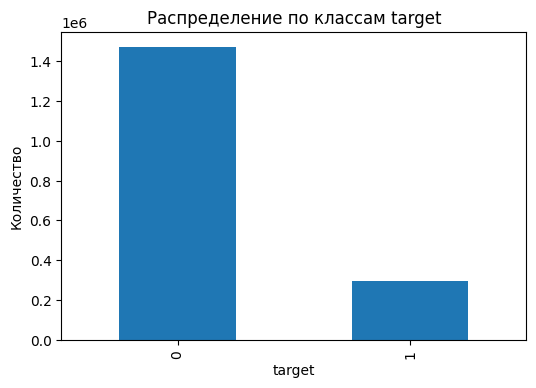

In [49]:
plt.figure(figsize=(6, 4))
train_balanced['target'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение по классам target')
plt.xlabel('target')
plt.ylabel('Количество')
plt.show()

In [50]:
train_balanced.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
1847391,178814,320786,780,0.000178,4223,3740.0,83.0,0,178814$320786
2229665,530361,1546654,1136,0.000672,457,365.0,7.0,0,530361$1546654
2504279,503667,1147465,2232,0.001531,9015,6990.0,82.0,0,503667$1147465
2079524,13451,22804,969,0.808594,6690,6090.0,4.0,0,13451$22804
1269339,103922,462430,512,0.209839,737,587.0,7.0,1,103922$462430


In [51]:
print(train_balanced.dtypes)

offer_depersanalised      int64
goods_depersanalised      int64
sum_length                int64
attrs+title_score       float64
offer_price               int64
goods_price             float64
goods_category_id       float64
target                    int64
id                       object
dtype: object


In [52]:
# Переходим к загрузке embedding. 
def load_embeddings(base_path):

    # Offer embeddings
    offer_img_embeds = np.load(f'{base_path}/offer_image_vectors/offer_image_vectors/embed_deperson.npy')
    offer_img_ids = np.load(f'{base_path}/offer_image_vectors/offer_image_vectors/items_deperson.npy')
    
    offer_txt_embeds = np.load(f'{base_path}/offer_title_vectors/offer_title_vectors/embed_deperson.npy')
    offer_txt_ids = np.load(f'{base_path}/offer_title_vectors/offer_title_vectors/items_deperson.npy')
    
    # Goods embeddings
    goods_img_embeds = np.load(f'{base_path}/goods_image_vectors/goods_image_vectors/embed_deperson.npy')
    goods_img_ids = np.load(f'{base_path}/goods_image_vectors/goods_image_vectors/items_deperson.npy')
    
    goods_txt_embeds = np.load(f'{base_path}/goods_title_vectors/goods_title_vectors/embed_deperson.npy')
    goods_txt_ids = np.load(f'{base_path}/goods_title_vectors/goods_title_vectors/items_deperson.npy')
    
    # Создаем словари для дальнейшего удобства работы при создании итогового датасета
    offer_img_dict = {int(id_): emb for id_, emb in zip(offer_img_ids, offer_img_embeds)}
    offer_txt_dict = {int(id_): emb for id_, emb in zip(offer_txt_ids, offer_txt_embeds)}
    goods_img_dict = {int(id_): emb for id_, emb in zip(goods_img_ids, goods_img_embeds)}
    goods_txt_dict = {int(id_): emb for id_, emb in zip(goods_txt_ids, goods_txt_embeds)}
    
    print("Loaded embeddings")
    
    return offer_img_dict, offer_txt_dict, goods_img_dict, goods_txt_dict


In [53]:
embeds = np.load('/kaggle/input/data/offer_image_vectors/offer_image_vectors/embed_deperson.npy')

print(f"shape: {embeds.shape}")
print(f"shape embedding: {embeds.shape[1]}")

shape: (457586, 256)
shape embedding: 256


In [54]:
def create_features_dataset(df, offer_img_dict, offer_txt_dict, 
                            goods_img_dict, goods_txt_dict):
    """
    Функция для создания датасета с эмбеддингами для каждой пары
    """

    n_samples = len(df)
    
    img_dim = len(next(iter(offer_img_dict.values())))
    txt_dim = len(next(iter(offer_txt_dict.values())))
    
    offer_img = np.zeros((n_samples, img_dim), dtype=np.float32)
    goods_img = np.zeros((n_samples, img_dim), dtype=np.float32)
    offer_txt = np.zeros((n_samples, txt_dim), dtype=np.float32)
    goods_txt = np.zeros((n_samples, txt_dim), dtype=np.float32)
    
    missing_counts = {'offer_img': 0, 'goods_img': 0, 'offer_txt': 0, 'goods_txt': 0}
    
    for i, (idx, row) in enumerate(tqdm(df.iterrows(), total=n_samples, desc="Extracting")):
        offer_id = int(row['offer_depersanalised'])
        goods_id = int(row['goods_depersanalised'])
        
        if offer_id in offer_img_dict:
            offer_img[i] = offer_img_dict[offer_id]
        else:
            missing_counts['offer_img'] += 1
        
        if offer_id in offer_txt_dict:
            offer_txt[i] = offer_txt_dict[offer_id]
        else:
            missing_counts['offer_txt'] += 1
        
        if goods_id in goods_img_dict:
            goods_img[i] = goods_img_dict[goods_id]
        else:
            missing_counts['goods_img'] += 1
        
        if goods_id in goods_txt_dict:
            goods_txt[i] = goods_txt_dict[goods_id]
        else:
            missing_counts['goods_txt'] += 1
    
    targets = df['target'].values if 'target' in df.columns else None
    
    # Посмотрим что у нас по проупскам в эмбеддах
    print("\nMissing embeddings:")
    for key, count in missing_counts.items():
        print(f"  {key}: {count:,}/{n_samples:,} ({100*count/n_samples:.2f}%)")
    
    return offer_img, goods_img, offer_txt, goods_txt, targets

In [55]:
# Конвертация numpy массивов в тензоры
class MatchingDataset(Dataset):

    def __init__(self, offer_img, goods_img, offer_txt, goods_txt, targets=None):
        self.offer_img = torch.FloatTensor(offer_img)
        self.goods_img = torch.FloatTensor(goods_img)
        self.offer_txt = torch.FloatTensor(offer_txt)
        self.goods_txt = torch.FloatTensor(goods_txt)
        
        if targets is not None:
            self.targets = torch.FloatTensor(targets)
        else:
            self.targets = None
    
    def __len__(self):
        return len(self.offer_img)
    
    def __getitem__(self, idx):
        if self.targets is not None:
            return (
                self.offer_img[idx],
                self.goods_img[idx],
                self.offer_txt[idx],
                self.goods_txt[idx],
                self.targets[idx]
            )
        else:
            return (
                self.offer_img[idx],
                self.goods_img[idx],
                self.offer_txt[idx],
                self.goods_txt[idx]
            )

In [56]:
offer_img_dict, offer_txt_dict, goods_img_dict, goods_txt_dict = load_embeddings(DATA_PATH)

Loaded embeddings


In [57]:
train_balanced = train_balanced.reset_index(drop=True)

In [58]:
offer_img, goods_img, offer_txt, goods_txt, targets = create_features_dataset(
    train_balanced,offer_img_dict, offer_txt_dict, goods_img_dict, goods_txt_dict
)

Extracting: 100%|██████████| 1767858/1767858 [01:40<00:00, 17557.79it/s]


Missing embeddings:
  offer_img: 356,017/1,767,858 (20.14%)
  goods_img: 1,306,791/1,767,858 (73.92%)
  offer_txt: 0/1,767,858 (0.00%)
  goods_txt: 0/1,767,858 (0.00%)


In [59]:
# Train/Val split
train_idx, val_idx = train_test_split(
    np.arange(len(offer_img)),
    test_size=VAL_SPLIT,
    stratify=targets,
    random_state=42
)

train_dataset = MatchingDataset(
    offer_img[train_idx], goods_img[train_idx],
    offer_txt[train_idx], goods_txt[train_idx],
    targets[train_idx]
)

val_dataset = MatchingDataset(
    offer_img[val_idx], goods_img[val_idx],
    offer_txt[val_idx], goods_txt[val_idx],
    targets[val_idx]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"train: {len(train_dataset):,} samples")
print(f"val: {len(val_dataset):,} samples")

# Create DataFrames for tabular features
train_df_for_features = train_balanced.iloc[train_idx].reset_index(drop=True)
val_df_for_features = train_balanced.iloc[val_idx].reset_index(drop=True)

train: 1,414,286 samples
val: 353,572 samples


In [60]:
class FeatureExtractor(nn.Module):
    """
    Сеть для извлечения признаков из эмбеддингов. Обучается на таргет с помощью classifier.
    fusion для получения признаков
    encoder для преобразования эмбеддингов в общее пр-во. 
    Сеть должна уметь извлекать информативные признаки, но не переобучится под тест. Сделаем её не слишком простой, но и не сложной.
    (PS: разница в скоре с сетью и без дает прирост скора ~0.001 при сабмите. Игрался со сложностью, кол-вом параметром и Norm слоями,
    но прироста скора не получил. Всё около 0.92)
    """
    def __init__(self, img_dim=256, txt_dim=64, output_dim=128):
        super().__init__()
        
        self.img_encoder = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.txt_encoder = nn.Sequential(
            nn.Linear(txt_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(640, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_dim),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(output_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, offer_img, goods_img, offer_txt, goods_txt, return_features=False):

        offer_img_feat = self.img_encoder(offer_img)
        goods_img_feat = self.img_encoder(goods_img) 
        
        offer_txt_feat = self.txt_encoder(offer_txt)
        goods_txt_feat = self.txt_encoder(goods_txt)
        
        combined = torch.cat([
            offer_img, goods_img,  
            offer_txt, goods_txt   
        ], dim=1)
        
        features = self.fusion(combined)
        
        if return_features:
            return features
            
        logits = self.classifier(features)
        return logits


model = FeatureExtractor(img_dim=IMG_DIM, txt_dim=TXT_DIM).to(DEVICE)
print(f"Model created: {sum(p.numel() for p in model.parameters()):,} parameters")

Model created: 249,441 parameters


In [61]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []
    
    for batch in tqdm(loader, desc="Training"):
        offer_img, goods_img, offer_txt, goods_txt, targets = batch
        offer_img, goods_img = offer_img.to(device), goods_img.to(device)
        offer_txt, goods_txt = offer_txt.to(device), goods_txt.to(device)
        targets = targets.to(device)
        
        logits = model(offer_img, goods_img, offer_txt, goods_txt)
        loss = criterion(logits.squeeze(), targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int).flatten()
        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy())
    
    return total_loss / len(loader), f1_score(all_targets, all_preds)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            offer_img, goods_img, offer_txt, goods_txt, targets = batch
            offer_img, goods_img = offer_img.to(device), goods_img.to(device)
            offer_txt, goods_txt = offer_txt.to(device), goods_txt.to(device)
            targets = targets.to(device)
            
            logits = model(offer_img, goods_img, offer_txt, goods_txt)
            loss = criterion(logits.squeeze(), targets)
            
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int).flatten()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())
    
    return total_loss / len(loader), f1_score(all_targets, all_preds)


print("ОБУЧЕНИЕ NN")


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_f1 = 0
patience = 2
patience_counter = 0

for epoch in range(NUM_EPOCHS_NN):
    print(f"\n epoch {epoch+1}/{NUM_EPOCHS_NN}")
    
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_f1 = validate(model, val_loader, criterion, DEVICE)
    
    print(f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'feature_extractor_best.pth')
        print(f"new best: {val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

model.load_state_dict(torch.load('feature_extractor_best.pth'))
print(f"\n Best Val F1: {best_val_f1:.4f}")

ОБУЧЕНИЕ NN

 epoch 1/7


Validating: 100%|██████████| 691/691 [00:09<00:00, 72.01it/s]


Train Loss: 0.1587, F1: 0.7851
Val Loss: 0.1371, F1: 0.8151
new best: 0.8151

 epoch 2/7


Validating: 100%|██████████| 691/691 [00:09<00:00, 70.39it/s]


Train Loss: 0.1395, F1: 0.8119
Val Loss: 0.1332, F1: 0.8223
new best: 0.8223

 epoch 3/7


Validating: 100%|██████████| 691/691 [00:09<00:00, 70.56it/s]


Train Loss: 0.1346, F1: 0.8187
Val Loss: 0.1306, F1: 0.8234
new best: 0.8234

 epoch 4/7


Validating: 100%|██████████| 691/691 [00:10<00:00, 67.50it/s]


Train Loss: 0.1318, F1: 0.8221
Val Loss: 0.1296, F1: 0.8261
new best: 0.8261

 epoch 5/7


Validating: 100%|██████████| 691/691 [00:09<00:00, 71.61it/s]


Train Loss: 0.1293, F1: 0.8255
Val Loss: 0.1291, F1: 0.8278
new best: 0.8278

 epoch 6/7


Validating: 100%|██████████| 691/691 [00:09<00:00, 74.10it/s]


Train Loss: 0.1272, F1: 0.8287
Val Loss: 0.1284, F1: 0.8273

 epoch 7/7


Validating: 100%|██████████| 691/691 [00:10<00:00, 66.74it/s]


Train Loss: 0.1257, F1: 0.8307
Val Loss: 0.1280, F1: 0.8264
Early stopping

 Best Val F1: 0.8278


In [62]:
def extract_neural_features(model, loader, device):
    """Извлекаем признаки из обученной модели"""
    model.eval()
    all_features = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting features"):
            offer_img, goods_img, offer_txt, goods_txt, *_ = batch
            
            offer_img = offer_img.to(device)
            goods_img = goods_img.to(device)
            offer_txt = offer_txt.to(device)
            goods_txt = goods_txt.to(device)
            
            features = model(offer_img, goods_img, offer_txt, goods_txt, return_features=True)
            all_features.append(features.cpu().numpy())
    
    return np.vstack(all_features)

In [63]:
train_neural_features = extract_neural_features(model, train_loader, DEVICE)
val_neural_features = extract_neural_features(model, val_loader, DEVICE)

Extracting features: 100%|██████████| 691/691 [00:10<00:00, 64.58it/s]


### Добавим фичей в наши данные. Для этого добавим косинусное сходство, эвклидово и манхеттанское расстояния. 
PS: Пробовал добавлять еще признаки , но повышения скора не увидел. 

In [64]:
def compute_embedding_features_batch(emb1, emb2):

    # Cos сходство
    dot_product = np.sum(emb1 * emb2, axis=1)
    norm1 = np.linalg.norm(emb1, axis=1)
    norm2 = np.linalg.norm(emb2, axis=1)
    cosine_sim = dot_product / (norm1 * norm2 + 1e-8)
    
    # эвклидово
    euclidean = np.linalg.norm(emb1 - emb2, axis=1)
    
    # манхеттан
    manhattan = np.sum(np.abs(emb1 - emb2), axis=1)
    
    return np.stack([cosine_sim, euclidean, manhattan], axis=1)


def extract_embedding_features(offer_img, goods_img, offer_txt, goods_txt):

    # Image features
    img_features = compute_embedding_features_batch(offer_img, goods_img)
    
    # Text features
    txt_features = compute_embedding_features_batch(offer_txt, goods_txt)
    
    # Combine
    all_features = np.hstack([img_features, txt_features])
    
    print("extract_embedding_features is done")
    
    return all_features

In [65]:
# в ходе работы появилась идея добавить метку на наличие эмбеддинга.
# создаем наши данные для CatBoost
def create_tabular_features(df, goods_img_dict):
    
    features = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating tabular features"):
        attrs_score = row['attrs+title_score']
        sum_length = row['sum_length']
        offer_price = row['offer_price']
        goods_price = row['goods_price'] if pd.notna(row['goods_price']) else offer_price
        category_id = row['goods_category_id'] if pd.notna(row['goods_category_id']) else 0
        
        if goods_price > 0:
            price_ratio = offer_price / goods_price
        else:
            price_ratio = 1.0
        
        price_diff = abs(offer_price - goods_price)
        price_log_ratio = np.log1p(price_ratio)
        
        goods_id = int(row['goods_depersanalised'])
        has_goods_img = 1.0 if goods_id in goods_img_dict else 0.0
        
        features.append([
            attrs_score,
            sum_length,
            sum_length / 1000.0,
            offer_price,
            goods_price,
            price_ratio,
            price_diff,
            price_log_ratio,
            category_id,
            has_goods_img
        ])
    
    return np.array(features, dtype=np.float32)

train_tabular = create_tabular_features(train_df_for_features,goods_img_dict)
val_tabular = create_tabular_features(val_df_for_features,goods_img_dict)

print("create_tabular_features is done")
print(f"Train tabular: {train_tabular.shape}")
print(f"Val tabular: {val_tabular.shape}")

Creating tabular features: 100%|██████████| 353572/353572 [00:24<00:00, 14377.93it/s]


create_tabular_features is done
Train tabular: (1414286, 10)
Val tabular: (353572, 10)


In [66]:
# Для train
train_offer_img = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
train_goods_img = np.array([train_dataset[i][1].numpy() for i in range(len(train_dataset))])
train_offer_txt = np.array([train_dataset[i][2].numpy() for i in range(len(train_dataset))])
train_goods_txt = np.array([train_dataset[i][3].numpy() for i in range(len(train_dataset))]) 

train_embedding_features = extract_embedding_features(
    train_offer_img, train_goods_img, 
    train_offer_txt, train_goods_txt
    )

val_offer_img = np.array([val_dataset[i][0].numpy() for i in range(len(val_dataset))])
val_goods_img = np.array([val_dataset[i][1].numpy() for i in range(len(val_dataset))])
val_offer_txt = np.array([val_dataset[i][2].numpy() for i in range(len(val_dataset))])
val_goods_txt = np.array([val_dataset[i][3].numpy() for i in range(len(val_dataset))])

val_embedding_features = extract_embedding_features(
    val_offer_img, val_goods_img,
    val_offer_txt, val_goods_txt
)

extract_embedding_features is done
extract_embedding_features is done


In [67]:
# Комбинируем все фичи
X_train_combined = np.hstack([
    train_neural_features,
    train_embedding_features,
    train_tabular
])

X_val_combined = np.hstack([
    val_neural_features,
    val_embedding_features,
    val_tabular
])

y_train = train_df_for_features['target'].values
y_val = val_df_for_features['target'].values

print(f"\n сombined features")


 сombined features


In [68]:
print("ОБУЧЕНИЕ CATBOOST")

catboost_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=8, #глубина дерева
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    auto_class_weights='Balanced',  # очень важный параметр при несбалансированных данных
    bootstrap_type='Bernoulli', # рандомно сэмплируем
    verbose=100,
    early_stopping_rounds=100,
    task_type='CPU'
)

catboost_model.fit(
    X_train_combined, y_train,
    eval_set=(X_val_combined, y_val),
    verbose=100
)

val_probs = catboost_model.predict_proba(X_val_combined)[:, 1]
val_preds = (val_probs >= 0.5).astype(int)
cb_val_f1 = f1_score(y_val, val_preds)

print(f"\n catboost Val F1: {cb_val_f1:.4f}")

ОБУЧЕНИЕ CATBOOST
0:	learn: 0.9766416	test: 0.9769997	best: 0.9769997 (0)	total: 632ms	remaining: 21m 3s
100:	learn: 0.9795317	test: 0.9798142	best: 0.9798142 (100)	total: 56.9s	remaining: 17m 49s
200:	learn: 0.9802029	test: 0.9804344	best: 0.9804463 (199)	total: 1m 50s	remaining: 16m 30s
300:	learn: 0.9805499	test: 0.9804595	best: 0.9805129 (261)	total: 2m 42s	remaining: 15m 18s
400:	learn: 0.9807396	test: 0.9806380	best: 0.9806416 (396)	total: 3m 32s	remaining: 14m 9s
500:	learn: 0.9809556	test: 0.9807353	best: 0.9807508 (490)	total: 4m 23s	remaining: 13m 8s
600:	learn: 0.9812046	test: 0.9808474	best: 0.9808543 (598)	total: 5m 14s	remaining: 12m 12s
700:	learn: 0.9813873	test: 0.9808376	best: 0.9808626 (601)	total: 6m 5s	remaining: 11m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9808625956
bestIteration = 601

Shrink model to first 602 iterations.

 catboost Val F1: 0.9294


In [69]:
# попробуем оптимизировать threshold, тк данные несбалансированы
best_f1 = 0
best_threshold = 0.5

for threshold in tqdm(np.arange(0.1, 0.9, 0.01), desc="Test thresholds"):
    preds = (val_probs >= threshold).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

improvement = (best_f1 - cb_val_f1) * 100

print(f"Default (0.5): F1 = {cb_val_f1:.4f}")
print(f"Optimal ({best_threshold:.3f}): F1 = {best_f1:.4f}")

Test thresholds: 100%|██████████| 80/80 [00:01<00:00, 49.63it/s]

Default (0.5): F1 = 0.9294
Optimal (0.790): F1 = 0.9396


In [70]:
X_train_combined = np.hstack([
    train_neural_features, 
    train_embedding_features,   
    train_tabular            
])

X_val_combined = np.hstack([
    val_neural_features,
    val_embedding_features,
    val_tabular
])

y_train = train_df_for_features['target'].values
y_val = val_df_for_features['target'].values

In [71]:
def extract_embeddings_from_dataset(dataset):
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    offer_imgs, goods_imgs = [], []
    offer_txts, goods_txts = [], []
    
    for batch in tqdm(loader, desc="Extracting embeddings"):
        offer_img, goods_img, offer_txt, goods_txt, *_ = batch
        offer_imgs.append(offer_img.numpy())
        goods_imgs.append(goods_img.numpy())
        offer_txts.append(offer_txt.numpy())
        goods_txts.append(goods_txt.numpy())
    
    return (
        np.vstack(offer_imgs),
        np.vstack(goods_imgs),
        np.vstack(offer_txts),
        np.vstack(goods_txts)
    )

In [72]:
print("INFERENCE")

test_df = test_df.reset_index(drop=True)
test_offer_img, test_goods_img, test_offer_txt, test_goods_txt, _ = create_features_dataset(
    test_df, offer_img_dict, offer_txt_dict, goods_img_dict, goods_txt_dict
)

test_dataset = MatchingDataset(
    test_offer_img, test_goods_img,
    test_offer_txt, test_goods_txt
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_neural_features = extract_neural_features(model, test_loader, DEVICE)

test_oi, test_gi, test_ot, test_gt = extract_embeddings_from_dataset(test_dataset)

test_embedding_features = extract_embedding_features(test_oi, test_gi, test_ot, test_gt)

test_tabular = create_tabular_features(test_df, goods_img_dict)

X_test_combined = np.hstack([
    test_neural_features,      # Из нейросети [N, 128]
    test_embedding_features,   # Similarity features [N, 6]
    test_tabular               # Табличные [N, ?]
])

print("\n ...catboost...")
test_probs = catboost_model.predict_proba(X_test_combined)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

print(f"   Positive: {test_preds.sum():,} ({100*test_preds.mean():.2f}%)")
print(f"   Negative: {(1-test_preds).sum():,} ({100*(1-test_preds.mean()):.2f}%)")
print(f"   Threshold: {best_threshold:.4f}")

INFERENCE


Extracting: 100%|██████████| 363835/363835 [00:25<00:00, 14167.04it/s]



Missing embeddings:
  offer_img: 72,580/363,835 (19.95%)
  goods_img: 285,461/363,835 (78.46%)
  offer_txt: 0/363,835 (0.00%)
  goods_txt: 0/363,835 (0.00%)


Extracting embeddings: 100%|██████████| 711/711 [00:06<00:00, 103.89it/s]


extract_embedding_features is done


Creating tabular features: 100%|██████████| 363835/363835 [00:24<00:00, 14695.44it/s]



 ...catboost...
   Positive: 47,306 (13.00%)
   Negative: 316,529 (87.00%)
   Threshold: 0.7900


In [73]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds
})

submission.to_csv('Submission.csv', index=False)

print("\n Submission")
print(submission.head(10))


 Submission
               id  target
0   64819$1396468       0
1   64819$1396235       0
2   64819$1396318       0
3  359959$1396281       0
4   142700$717657       0
5   142713$717657       0
6   230214$717657       0
7  106880$1396551       0
8  460062$1396292       0
9   142719$717657       0


### Соберем итоги по всему проекту

In [74]:
print(f"Neural Network only:           F1 = {best_val_f1:.4f}")
print(f"CatBoost (threshold=0.5):      F1 = {cb_val_f1:.4f}")
print(f"CatBoost (optimized):          F1 = {best_f1:.4f}")
print(f"Optimal threshold:             {best_threshold:.3f}")

Neural Network only:           F1 = 0.8278
CatBoost (threshold=0.5):      F1 = 0.9294
CatBoost (optimized):          F1 = 0.9396
Optimal threshold:             0.790


## **Итоги:**

Что было сделано:

* Обработка пропусков в данных
* Добавление фичей от эмбеддингов (косинусное сходство и расстояния)
* Обучена NN для получения признаков от эмбеддингов
* Обучен CatBoost для решения задачи
* Оптимизация порога

Что не было сделано:
* Повышение итогового скора для топ-5
  
Какие были эксперименты:
* Определение оптимального соотношения классов в данных (ratio)
* Реализован baseline чисто с CatBoost для получения отправной точки
* Были эксперименты с seed
* K-Fold подход и усреднение результата
* Глубина NN и параметры в CatBoost

    